### Programita de prueba para visualizar redes dinámicas

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import ffmpeg

plt.rcParams['text.usetex'] = True

In [2]:
class model:
    def __init__(
        self,
        n_agents,
        w_min=1e-17,
        w_0=None,
        G=None,
        additive=False,
        theta=0,
        save_every=np.inf,
        upd_w_every=np.inf,
        upd_graph_every=np.inf,
        plot_every=np.inf,
        figpath=None,
    ):  # sourcery skip: assign-if-exp
        self.N = n_agents
        self.w_min = w_min
        self.G = G
        self.additive = additive
        if self.G is not None:
            self.posi = {i: self.G.nodes[i]["pos"] for i in range(self.N)}
            self.theta = theta
        self.update_w = upd_w_every
        self.update_links = upd_graph_every
        self.every = save_every
        self.plot = plot_every
        if self.plot != np.inf:
            self.fig, self.ax = plt.subplots(dpi=150)
            self.ax.set_xlim([-0.03, 1.03])
            self.ax.set_ylim([-0.03, 1.03])
        self.figpath = figpath
        self.temppath = os.path.join(self.figpath, "temp")
        self.figpath = figpath
        # Initialize n agents with random risks and wealth between (0, 1]
        # and normalize wealth
        # n[i, 0] is the wealth and n[i, 1] is the risk of agent i
        self.n = np.random.rand(self.N, 2)
        if w_0 is not None:
            self.n[:, 0] = w_0
        else:
            self.n[:, 0] = self.n[:, 0] / (np.sum(self.n[:, 0]))
        self.gini = [self.get_gini()]
        self.n_active = [self.get_actives()]

    def get_opponents(self):
        if self.G is None:
            random_array = np.random.randint(0, self.N, self.N)
            indices = np.arange(0, self.N)
            # Create array of random numbers that are not equal to the index
            # If i=j then assign j'=i+1 (j'=0 if i=N-1)
            random_array = np.where(
                random_array == indices, (random_array + 1) % self.N, random_array
            )
        else:
            random_array = np.full(self.N, fill_value=-1)
            for i in range(self.N):
                if neighbors := list(nx.all_neighbors(self.G, i)):
                    random_array[i] = np.random.choice(neighbors)

        return random_array

    def is_valid(self, i, j):
        # Check if both agents have w > w_min
        return (self.n[i, 0] > self.w_min) and (self.n[j, 0] > self.w_min)

    def get_dw(self, i, j):
        return np.minimum(self.n[i, 0] * self.n[i, 1], self.n[j, 0] * self.n[j, 1])

    def get_gini(self):
        w = np.sort(self.n[:, 0])
        p_cumsum = np.cumsum(w) / np.sum(w)
        B = np.sum(p_cumsum) / self.N
        return 1 + 1 / self.N - 2 * B

    def get_actives(self):
        return np.sum(self.n[:, 0] > self.w_min)

    def get_liquidity():
        return

    def update_wealth(self, i, j, dw):
        self.n[i, 0] += dw
        self.n[j, 0] -= dw

    def choose_winner(self, i, j):
        raise Exception("You need to choose a valid model.")

    def update_weights(self):
        w = dict(enumerate(self.n[:, 0]))
        nx.set_node_attributes(self.G, w, "weight")

    def plot_snapshot(self, mcs):
        ## Esto se tiene que borrar y escribir mejor
        w = dict(enumerate(self.n[:, 0]))
        a = np.array(list(w.values()))

        dead_nodes = [node for node, weight in w.items() if weight < self.w_min]

        node_size = 500 * np.sqrt(a)
        node_colors = plt.cm.coolwarm(100 * a)
        edge_colors = [
            "r" if (e[0] in dead_nodes or e[1] in dead_nodes) else "black"
            for e in self.G.edges
        ]

        filename = os.path.join(self.temppath, "test_{:05d}.png".format(mcs))

        self.ax.clear()
        self.ax.set_title(f"t = {mcs}")
        nx.draw(
            self.G,
            node_size=node_size,
            width=0.2,
            pos=self.posi,
            node_color=node_colors,
            edge_color=edge_colors,
            ax=self.ax,
        )
        self.fig.savefig(filename, format="PNG")

    def MCS(self, steps):
        """
        Main MC loop
        """
        for mcs in range(steps):
            if mcs % self.plot == 0:
                self.plot_snapshot(mcs)

            j = self.get_opponents()

            for i, ji in enumerate(j):
                # Check both agents have w > w_min and node is not isolated
                if self.is_valid(i, ji) and ji != -1:
                    dw = self.get_dw(i, ji)
                    winner = self.choose_winner(i, ji)
                    dw = np.where(winner == i, dw, -dw)
                    self.update_wealth(i, ji, dw)

            # After self.update_w update weights
            if mcs % self.update_w == 0:
                self.update_weights()

            # Recompute the links if the network is dynamic
            if (mcs + 1) % self.update_links == 0 and self.G is not None:
                self.G = nx.geographical_threshold_graph(
                    self.N,
                    theta=self.theta,
                    weight=self.n[:, 0],
                    dim=2,
                    pos=self.posi,
                    additive=self.additive,
                )
            # After self.every MCS append new Gini index
            if (mcs + 1) % self.every == 0:
                self.gini.append(self.get_gini())
                self.n_active.append(self.get_actives())

In [3]:
class YSmodel(model):
    def __init__(self, n_agents=200, f=0, **kwargs):
        super().__init__(n_agents, **kwargs)
        # f is the social protection factor
        self.f = f

    def choose_winner(self, i, j):
        p = 0.5 + self.f * (
            (self.n[j, 0] - self.n[i, 0]) / (self.n[i, 0] + self.n[j, 0])
        )
        return np.random.choice([i, j], p=[p, 1 - p])

In [4]:
def delete_images(figpath):
    temppath = os.path.join(figpath, "temp")
    for file in os.listdir(temppath):
        print(file)
        if file.endswith(".png"):
            os.remove(os.path.join(temppath, file))

### Parámetros comunes del sistema y la red

In [5]:
moviepath = os.path.join(os.getcwd(), "movies")
figpath = os.path.join(os.getcwd(), "figs")
datapath = os.path.join(os.getcwd(), "data")

# Numero de nodos = Numero de agentes
n = 200
# Pesos de los nodos = riquezas iniciales de los agentes
a_0 = np.random.rand(n)
a_0 /= np.sum(a_0)
w_0 = dict(enumerate(a_0))

f_set = [0, 0.05, 0.3]

MCS = 50000

upd_w = 30
upd_g = 500
plot_every = upd_w

## Red aditiva

Conectividad: 4.79


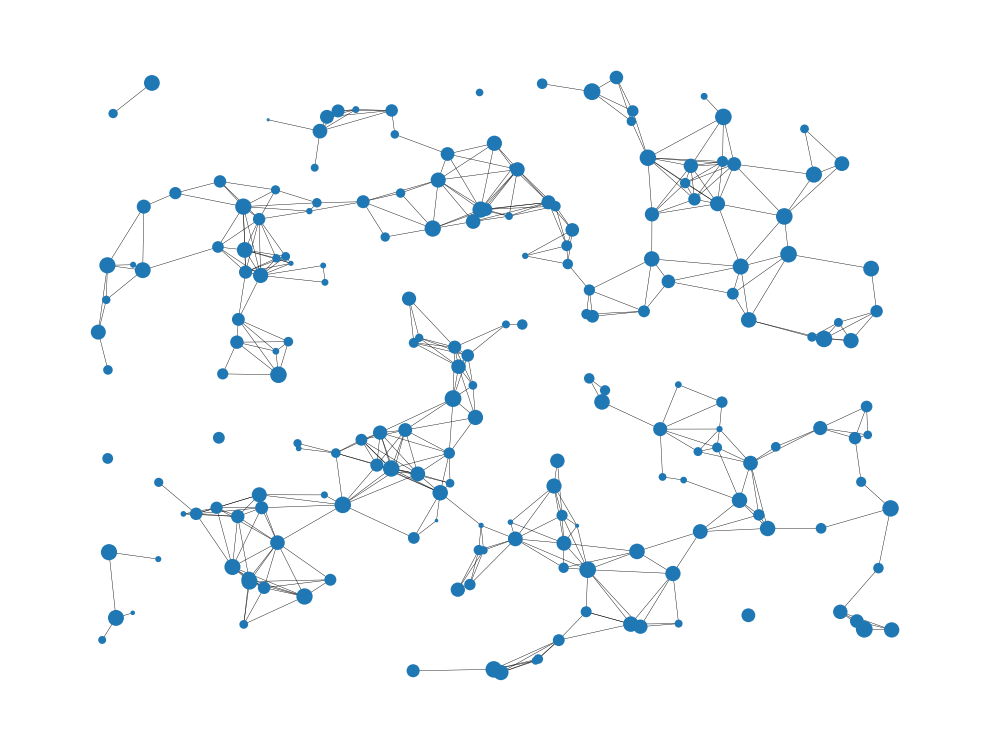

In [8]:
# Red aditiva
theta_add = 500 / (2 * n)

GTG_add = nx.geographical_threshold_graph(
    n, theta=theta_add, weight=w_0, dim=2, additive=True
)

posi = {i: GTG_add.nodes[i]["pos"] for i in range(n)}

print("Conectividad: {:.2f}".format(np.mean(list(dict(nx.degree(GTG_add)).values()))))

fig = plt.figure(dpi=150)
nx.draw(GTG_add, node_size=25 * n * a_0, width=0.2, pos=posi)

#### Red aditiva fija

test_29130.png
test_12060.png
test_35430.png
test_48960.png
test_06030.png
test_22200.png
test_30090.png
test_46800.png
test_04410.png
test_03030.png
test_36510.png
test_35070.png
test_31350.png
test_42120.png
test_48510.png
test_15480.png
test_29280.png
test_25920.png
test_28350.png
test_47340.png
test_34860.png
test_19170.png
test_33570.png
test_40050.png
test_08550.png
test_23490.png
test_03390.png
test_35010.png
test_24930.png
test_48180.png
test_31560.png
test_38580.png
test_23340.png
test_16110.png
test_31050.png
test_37680.png
test_16560.png
test_05910.png
test_23670.png
test_00960.png
test_38880.png
test_13260.png
test_43470.png
test_15720.png
test_49560.png
test_16050.png
test_19860.png
test_06270.png
test_38400.png
test_00210.png
test_12510.png
test_04110.png
test_16470.png
test_15300.png
test_06630.png
test_15840.png
test_17370.png
test_01830.png
test_14700.png
test_03810.png
test_36090.png
test_04980.png
test_28590.png
test_09510.png
test_12030.png
test_42240.png
test_05130

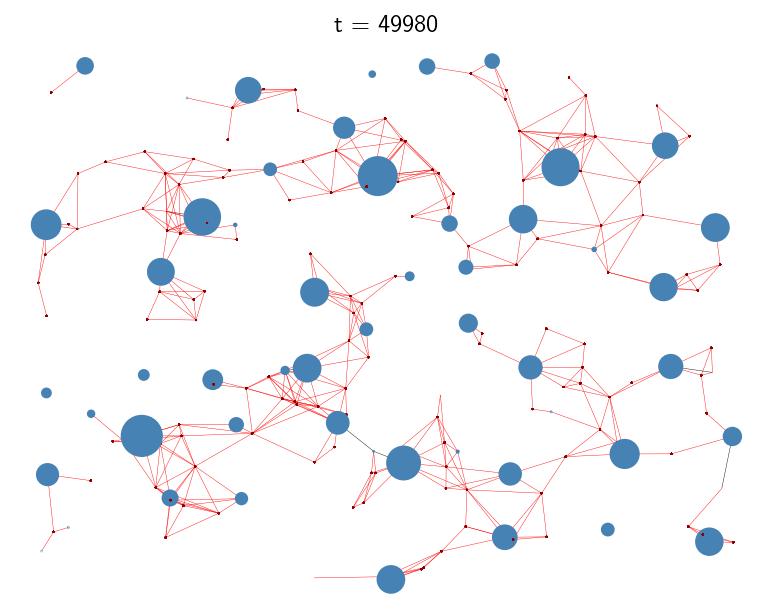

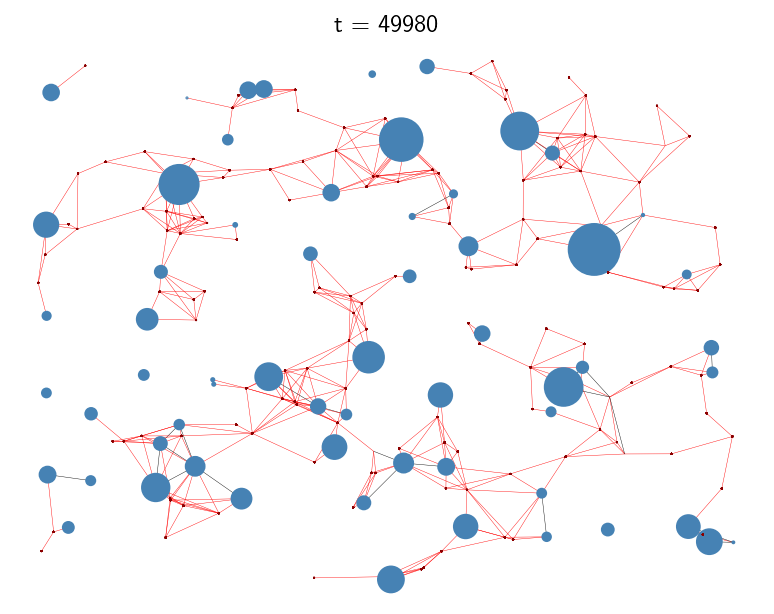

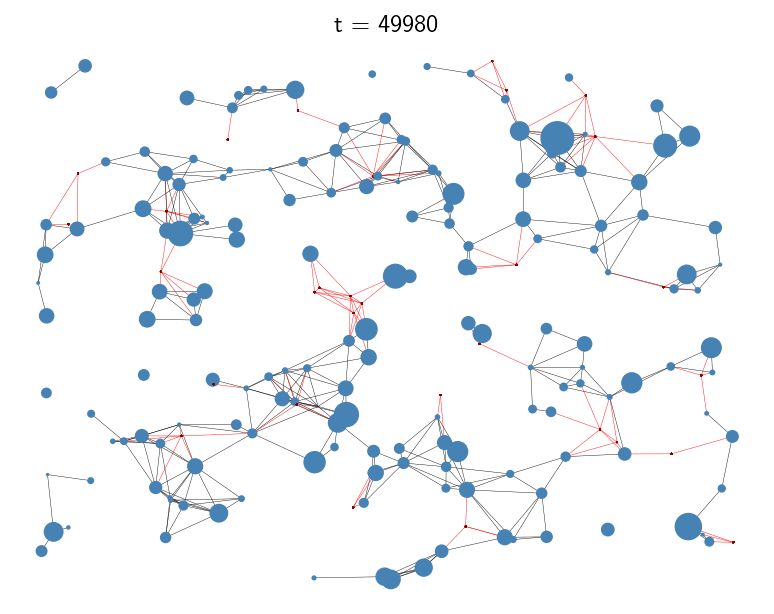

In [10]:
for f in f_set:
    model = YSmodel(
        n,
        w_min=1e-17,
        w_0=a_0,
        G=GTG_add,
        additive=True,
        theta=theta_add,
        save_every=np.inf,
        upd_w_every=upd_w,
        upd_graph_every=np.inf,
        plot_every=plot_every,
        figpath=figpath,
        f=f,
    )

    model.MCS(MCS)

    # Make movie
    (
        ffmpeg.input(
            os.path.join(figpath, "temp", "test_*.png"),
            pattern_type="glob",
            framerate=30,
        )
        .output(os.path.join(moviepath, "f={:.2f}_add_fix.mp4".format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, "w_f={:.2f}_add_fix").format(f), model.n[:, 0])

    del model

    delete_images(figpath)

#### Red aditiva 'dinámica'

test_29130.png
test_12060.png
test_35430.png
test_48960.png
test_06030.png
test_22200.png
test_30090.png
test_46800.png
test_04410.png
test_03030.png
test_36510.png
test_35070.png
test_31350.png
test_42120.png
test_48510.png
test_15480.png
test_29280.png
test_25920.png
test_28350.png
test_47340.png
test_34860.png
test_19170.png
test_33570.png
test_40050.png
test_08550.png
test_23490.png
test_03390.png
test_35010.png
test_24930.png
test_48180.png
test_31560.png
test_38580.png
test_23340.png
test_16110.png
test_31050.png
test_37680.png
test_16560.png
test_05910.png
test_23670.png
test_00960.png
test_38880.png
test_13260.png
test_43470.png
test_15720.png
test_49560.png
test_16050.png
test_19860.png
test_06270.png
test_38400.png
test_00210.png
test_12510.png
test_04110.png
test_16470.png
test_15300.png
test_06630.png
test_15840.png
test_17370.png
test_01830.png
test_14700.png
test_03810.png
test_36090.png
test_04980.png
test_28590.png
test_09510.png
test_12030.png
test_42240.png
test_05130

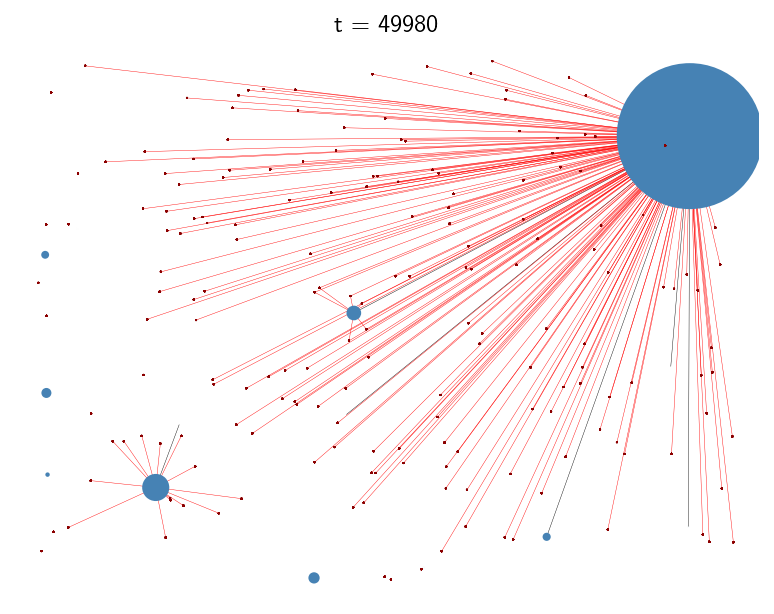

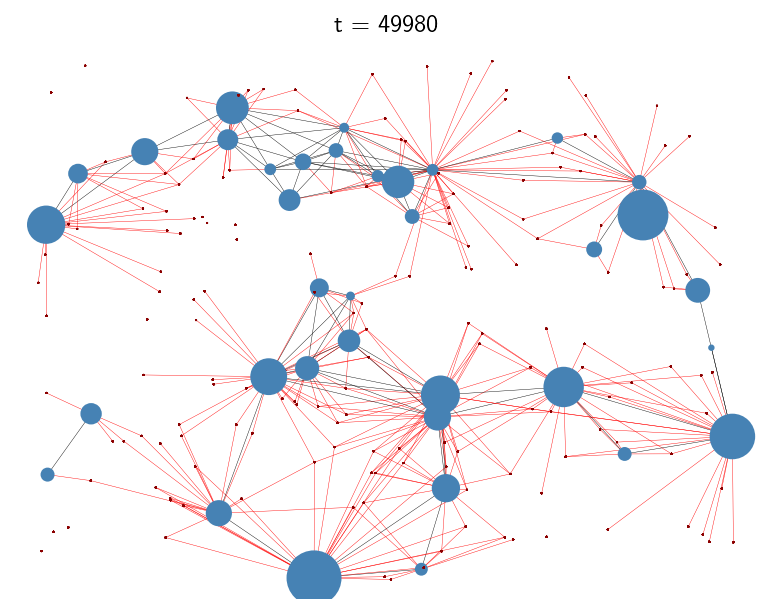

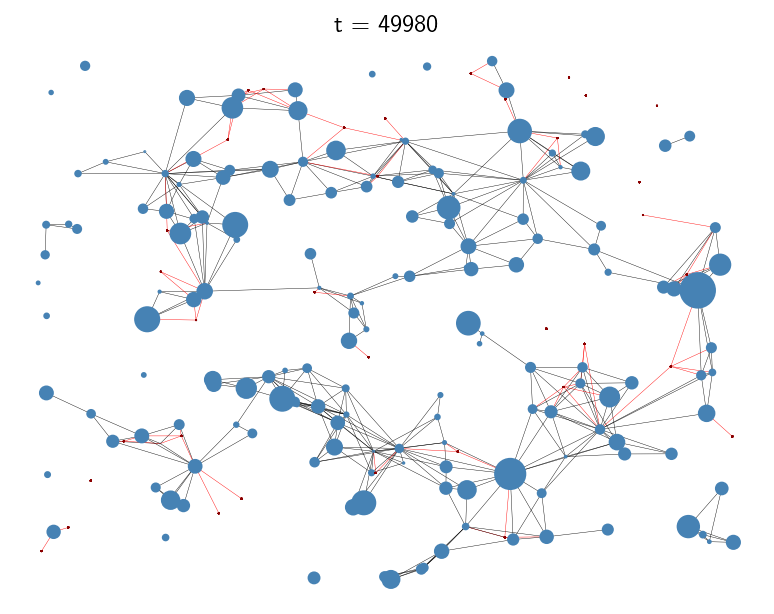

In [12]:
for f in f_set:
    model = YSmodel(
        n,
        w_min=1e-17,
        w_0=a_0,
        G=GTG_add,
        additive=True,
        theta=theta_add,
        save_every=np.inf,
        upd_w_every=upd_w,
        upd_graph_every=upd_g,
        plot_every=plot_every,
        figpath=figpath,
        f=f,
    )
    model.MCS(MCS)

    # Make movie
    (
        ffmpeg.input(
            os.path.join(figpath, "temp", "test_*.png"),
            pattern_type="glob",
            framerate=30,
        )
        .output(os.path.join(moviepath, "f={:.2f}_add_din.mp4".format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, "w_f={:.2f}_add_din").format(f), model.n[:, 0])

    del model

    delete_images(figpath)

## Red multiplicativa

Conectividad: 4.61


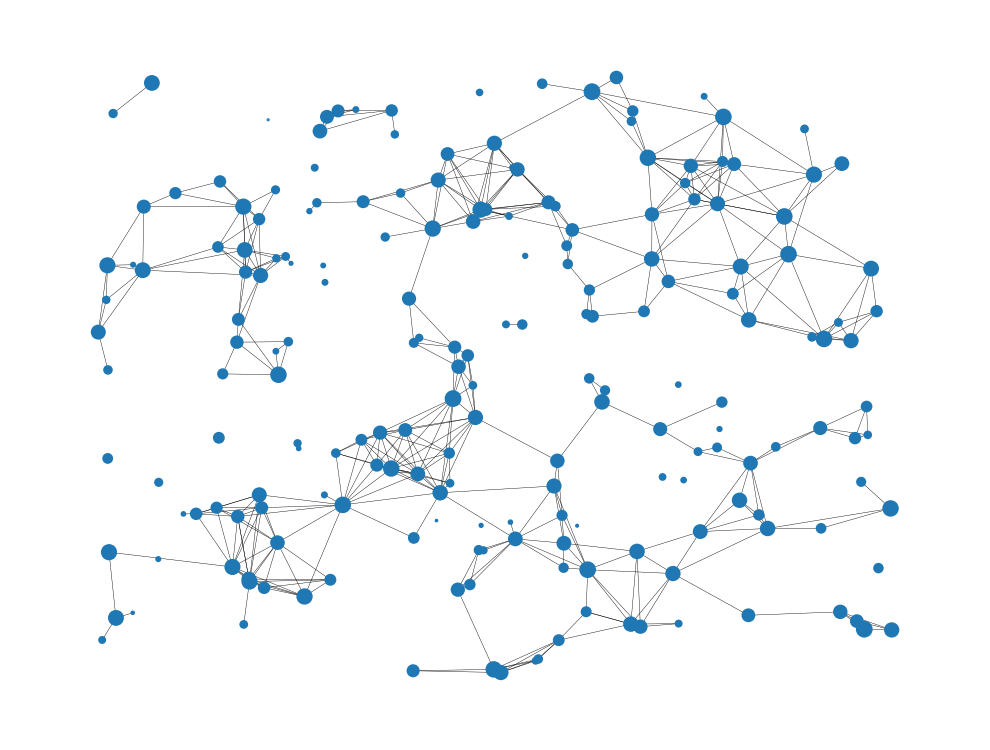

In [9]:
theta_mul = 250 / (2 * n**2)

# Red multiplicativa
GTG_mul = nx.geographical_threshold_graph(
    n, theta=theta_mul, weight=w_0, dim=2, pos=posi, additive=False
)

print("Conectividad: {:.2f}".format(np.mean(list(dict(nx.degree(GTG_mul)).values()))))

fig = plt.figure(dpi=150)
nx.draw(GTG_mul, node_size=25 * n * a_0, width=0.2, pos=posi)

#### Red multiplicativa fija

test_29130.png
test_12060.png
test_35430.png
test_48960.png
test_06030.png
test_22200.png
test_30090.png
test_46800.png
test_04410.png
test_03030.png
test_36510.png
test_35070.png
test_31350.png
test_42120.png
test_48510.png
test_15480.png
test_29280.png
test_25920.png
test_28350.png
test_47340.png
test_34860.png
test_19170.png
test_33570.png
test_40050.png
test_08550.png
test_23490.png
test_03390.png
test_35010.png
test_24930.png
test_48180.png
test_31560.png
test_38580.png
test_23340.png
test_16110.png
test_31050.png
test_37680.png
test_16560.png
test_05910.png
test_23670.png
test_00960.png
test_38880.png
test_13260.png
test_43470.png
test_15720.png
test_49560.png
test_16050.png
test_19860.png
test_06270.png
test_38400.png
test_00210.png
test_12510.png
test_04110.png
test_16470.png
test_15300.png
test_06630.png
test_15840.png
test_17370.png
test_01830.png
test_14700.png
test_03810.png
test_36090.png
test_04980.png
test_28590.png
test_09510.png
test_12030.png
test_42240.png
test_05130

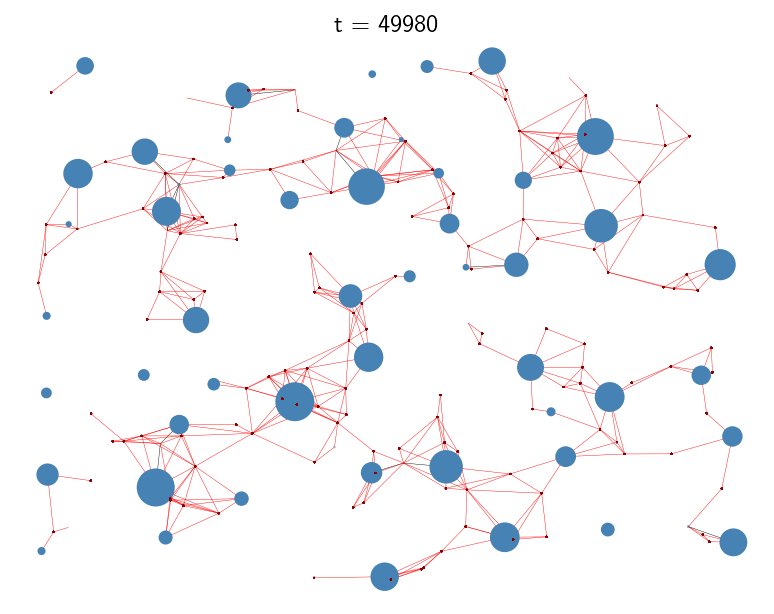

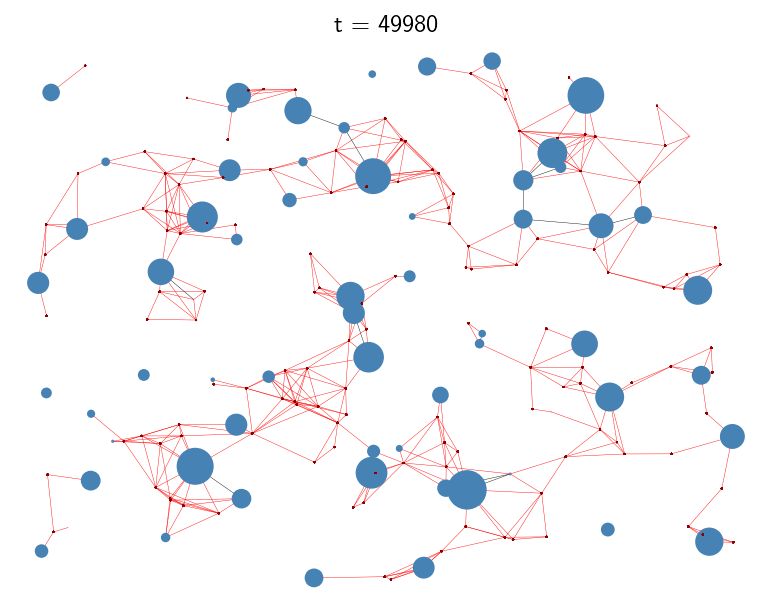

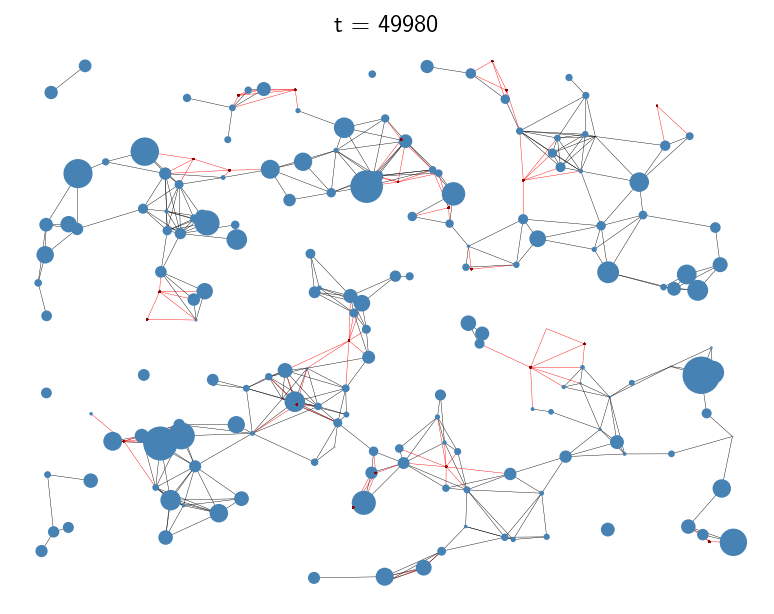

In [13]:
for f in f_set:
    model = YSmodel(
        n,
        w_min=1e-17,
        w_0=a_0,
        G=GTG_add,
        additive=False,
        theta=theta_mul,
        save_every=np.inf,
        upd_w_every=upd_w,
        upd_graph_every=np.inf,
        plot_every=plot_every,
        figpath=figpath,
        f=f,
    )
    model.MCS(MCS)

    # Make movie
    (
        ffmpeg.input(
            os.path.join(figpath, "temp", "test_*.png"),
            pattern_type="glob",
            framerate=30,
        )
        .output(os.path.join(moviepath, "f={:.2f}_mul_fix.mp4".format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, "w_f={:.2f}_mul_fix").format(f), model.n[:, 0])

    del model

    delete_images(figpath)

#### Red multiplicativa 'dinámica'

test_29130.png
test_12060.png
test_35430.png
test_48960.png
test_06030.png
test_22200.png
test_30090.png
test_46800.png
test_04410.png
test_03030.png
test_36510.png
test_35070.png
test_31350.png
test_42120.png
test_48510.png
test_15480.png
test_29280.png
test_25920.png
test_28350.png
test_47340.png
test_34860.png
test_19170.png
test_33570.png
test_40050.png
test_08550.png
test_23490.png
test_03390.png
test_35010.png
test_24930.png
test_48180.png
test_31560.png
test_38580.png
test_23340.png
test_16110.png
test_31050.png
test_37680.png
test_16560.png
test_05910.png
test_23670.png
test_00960.png
test_38880.png
test_13260.png
test_43470.png
test_15720.png
test_49560.png
test_16050.png
test_19860.png
test_06270.png
test_38400.png
test_00210.png
test_12510.png
test_04110.png
test_16470.png
test_15300.png
test_06630.png
test_15840.png
test_17370.png
test_01830.png
test_14700.png
test_03810.png
test_36090.png
test_04980.png
test_28590.png
test_09510.png
test_12030.png
test_42240.png
test_05130

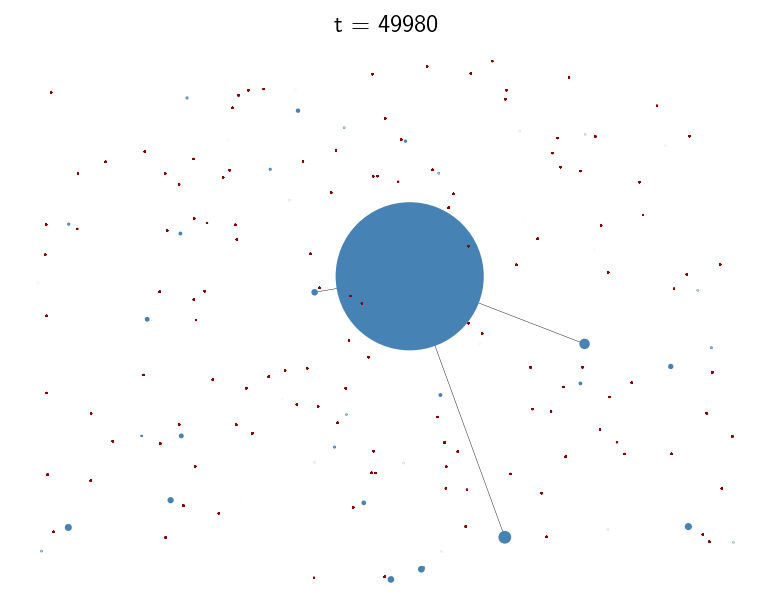

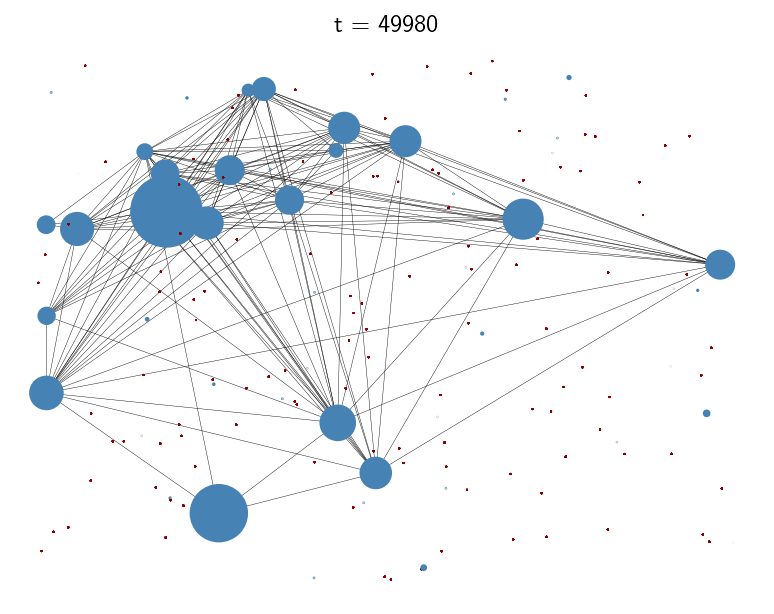

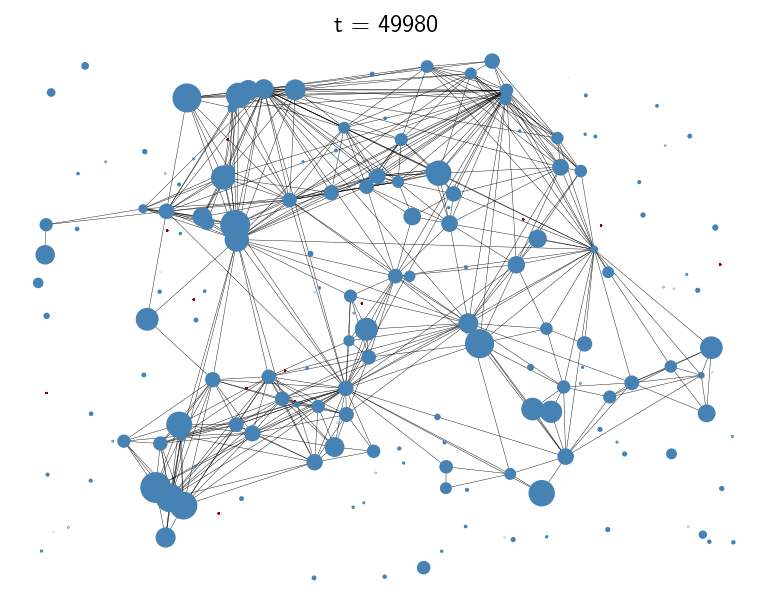

In [14]:
for f in f_set:
    model = YSmodel(
        n,
        w_min=1e-17,
        w_0=a_0,
        G=GTG_add,
        additive=False,
        theta=theta_mul,
        save_every=np.inf,
        upd_w_every=upd_w,
        upd_graph_every=upd_g,
        plot_every=plot_every,
        figpath=figpath,
        f=f,
    )
    model.MCS(MCS)

    # Make movie
    (
        ffmpeg.input(
            os.path.join(figpath, "temp", "test_*.png"),
            pattern_type="glob",
            framerate=30,
        )
        .output(os.path.join(moviepath, "f={:.2f}_mul_din.mp4".format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, "w_f={:.2f}_mul_din").format(f), model.n[:, 0])

    del model

    delete_images(figpath)